# EpiMapper

Welcome! This repository carries out core analyses and visualizations for exploring the utility of interictal iEEG functional connectivity on predicting outcomes in surgically-treated drug resistant epilepsy patients, using knowledge of the surgical resection zone.

This serves as a supplement to our paper in preparation, entitled "High interictal connectivity within resection zone is associated with favorable post-surgical outcomes in focal epilepsy patients." Please see paper for details on image acquisition, processing, and analysis.

# 1. Import Key Modules

In [68]:
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy as sp
import seaborn as sb
import csv
from scipy import stats
import matplotlib.pyplot as plt
import random
import glob
%matplotlib inline
from sklearn import metrics
sb.set(context="poster", font_scale=0.9)
sb.set_style("whitegrid")

mycmap = [ "#A3BFFF","#5773B3", "#001E5D", "#9FD5A6","#53895A","#205627"]
mycmap2= [ "#5773B3", "#53895A"]

# 2. Define some useful functions

In [3]:
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / im_sum

def perm_p_val(A, B, metric=np.mean, numResamples=10000):
    """
    two-sided two-sample permutation test
    """
    observedDiff = abs(metric(A) - metric(B))
    combined = np.concatenate([A, B])
    numA = len(A)    
    resampleDiffs = np.zeros(numResamples,dtype='float')
    for resampleInd in range(numResamples):
        permutedCombined = np.random.permutation(combined)
        diff = metric(permutedCombined[:numA]) - metric(permutedCombined[numA:])
        resampleDiffs[resampleInd] = diff 

    pVal = (np.sum(resampleDiffs > observedDiff) + np.sum(resampleDiffs < -observedDiff))/float(numResamples)
    return pVal

def mat2line(mymat):
    """
    unravels 2D adjacency matrix into a 1D vector
    """
    mymatline =  mymat[np.triu_indices(np.shape(mymat)[0], 1)]
    return mymatline

def line2mat(myline, n_nodes):
    """"
    converts 1D vector back to 2D adjacency matrix
    """
    mymat = np.zeros((n_nodes, n_nodes))
    mymat[np.triu_indices(n_nodes, 1)] = myline
    mymat = mymat + zip(*( mymat))
    return mymat

# 3. Run Strength Selectivity Analysis

We retrospectively studied 27 adult patients undergoing pre-surgical evaluation for drug-resistant epilepsy. Patients were divided into good outcome (Engel I, or ILAE 1-2) and poor outcome (Engel II-IV or ILAE 3-6) groups. For each subject, we obtained one clip of interictal data consisting of the first 6 hours of artifact-free recording at least 4 hours removed from any seizure event. Raw patient data is publicly available on the iEEG portal (ieeg.org).

From the interictal data, we computed functional networks across broadband and four frequency bands: α/θ (5-15 Hz), β (15-25 Hz), low-γ (30-40 Hz), and high-γ (95-105 Hz), using the Echobase pipeline: https://github.com/akhambhati/Echobase (Khambhati et al). 
The networks were averaged across the full 6 hours to obtain one function network for each patient for each frequency band. Next, we defined the strength selectivity of the resection zone as the spatial overlap between the nodes within the resection zone and the highly synchronous nodes.


In [5]:
# vector of subject names
subjects= ['HUP064','HUP065', 'HUP068','HUP070', 'HUP073', 'HUP074','HUP075','HUP078', 'HUP080', 'HUP082' ,'HUP083', 'HUP086' ,'HUP087' ,
           'HUP088', 'HUP094', 'HUP105', 'HUP106','HUP107', 'HUP111A','Study012','Study016','Study017','Study019','Study020', 
           'Study022','Study028','Study029']

#associated outcomes (0=good, 1=poor)
outcomes = [0,0, 0 ,0,0,0,1, 1,1, 0 ,1, 0 ,0 ,0, 0,0, 0, 0,0,0,1,1,1,1,1, 1,1]

bad_idx = np.where(np.array(outcomes) ==1)
good_idx = np.where(np.array(outcomes) ==0)

# Define base folder for dataset
basefolder = '../Data/Processed/'
freq_bands_strength = ['strength_broadband_CC','strength_alphatheta','strength_beta','strength_lowgamma','strength_highgamma',]
freq_bands_adj = ['all_adj_broadband_CC','all_adj_alphatheta','all_adj_beta','all_adj_lowgamma','all_adj_highgamma']
titles = ['broadband', '$\\alpha-\\theta$', '$\\beta$', '$\\gamma_{low}$','$\gamma_{high}$']
numfreqs = len(titles)

adjs = {}
electrodes_dict = {}
resected_dict = {}
strength_avg_dict = {}

zvals = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2]
myscore = np.zeros((len(zvals),5,np.shape(outcomes)[0]))
roc_auc = np.zeros((5,np.shape(outcomes)[0]))

for sub_idx, subject in enumerate(subjects):
    myfiles_strength = glob.glob(basefolder + subject + '/*nodestrength.npz')
    myfiles_adj = glob.glob(basefolder + subject + '/*multiband.npz')
    
    resected_fn = basefolder + 'resected_electrodes_5/' + subject + '_resected_electrodes_dilate_5.csv'
    resected_idx = []
  
    electrodes_fn = basefolder + subject + '/' + subject + '_centroids_mni_snapped_final.csv'
    electrodes = []
    
    with open(electrodes_fn ) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        for row in csvReader:
            electrodes.append(row[4])     
    electrodes_dict[sub_idx] = electrodes
    
    with open(resected_fn) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        for row in csvReader:
            resected_idx.append(row[0])
    resected_idx =  map(int, resected_idx) 
    
    for ctr, myfilename_adj in enumerate(myfiles_adj):
        adj_file = np.load(myfilename_adj)
        adjs[sub_idx] = np.squeeze([adj_file[freq_bands_adj[0]],adj_file[freq_bands_adj[1]],
                              adj_file[freq_bands_adj[2]],adj_file[freq_bands_adj[3]],
                              adj_file[freq_bands_adj[4]]] )
    
    for ctr, myfilename in enumerate(myfiles_strength):
        cres_fn = myfilename
        cres_file = np.load(cres_fn)
        node_strength = np.squeeze([cres_file[freq_bands_strength[0]],cres_file[freq_bands_strength[1]],
                              cres_file[freq_bands_strength[2]],cres_file[freq_bands_strength[3]],
                              cres_file[freq_bands_strength[4]]] )
        if ctr == 0:
            node_strength_to_avg= [node_strength]    
        else:
            node_strength_to_avg=np.append(node_strength_to_avg, [node_strength],axis=0)    
    
    # this is the final network!           
    node_strength_average = np.mean(node_strength_to_avg,axis=0)
    z_normed_node_strength_average= stats.zscore(node_strength_average,axis=1)
    
    # get a binary is_resected row
    is_resected = np.zeros(np.shape(node_strength_average)[1])
    is_resected[resected_idx] = 1
    resected_dict[sub_idx] = is_resected
    strength_avg_dict[sub_idx] = z_normed_node_strength_average
    
    # what are the "strong nodes" 
    for z_idx, z_thresh in enumerate(zvals):  
        strong_nodes= z_normed_node_strength_average >= z_thresh
        for freq_idx in range(5):
            myscore[z_idx,freq_idx,sub_idx] = dice(strong_nodes[freq_idx], is_resected) 
    

# 4. Visualize node strength in relation to resection zone

Here we visualize node strength, along with the resected electrodes for an example good outcome subject (HUP082)

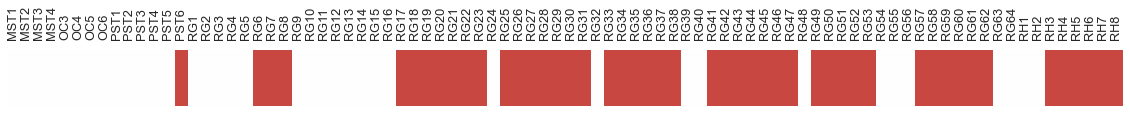

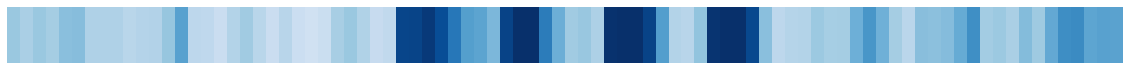

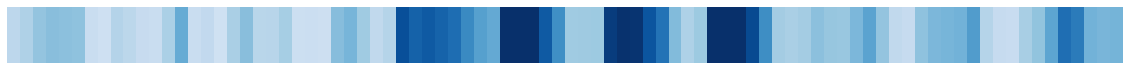

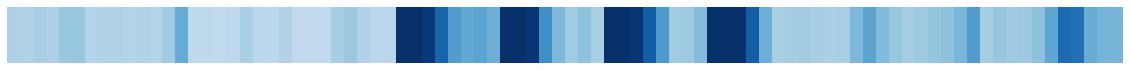

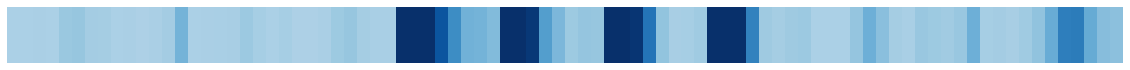

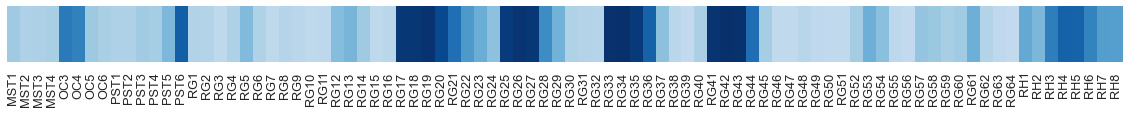

In [63]:
sub_idx=9
sb.set(context="poster", font_scale=0.8)
myelectrodes = electrodes_dict[sub_idx]

fig = plt.figure(figsize=(20,1))
ax = sb.heatmap([resected_dict[sub_idx]],cmap='RdGy_r',xticklabels=myelectrodes,yticklabels='',vmin=-1.5,vmax=1.5,cbar=None)
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)
plt.show()

fig = plt.figure(figsize=(20,1))
sb.heatmap([strength_avg_dict[sub_idx][0,:]],xticklabels='',yticklabels='',cmap='Blues',vmin=-2,vmax=2,cbar=None)
plt.show()

fig = plt.figure(figsize=(20,1))
sb.heatmap([strength_avg_dict[sub_idx][1,:]],xticklabels='',yticklabels='',cmap='Blues',vmin=-2,vmax=2,cbar=None)
plt.show()

fig = plt.figure(figsize=(20,1))
sb.heatmap([strength_avg_dict[sub_idx][2,:]],xticklabels='',yticklabels='',cmap='Blues',vmin=-2,vmax=2,cbar=None)
plt.show()

fig = plt.figure(figsize=(20,1))
sb.heatmap([strength_avg_dict[sub_idx][3,:]],xticklabels='',yticklabels='',cmap='Blues',vmin=-2,vmax=2,cbar=None)
plt.show()

fig = plt.figure(figsize=(20,1))
sb.heatmap([strength_avg_dict[sub_idx][4,:]],xticklabels=myelectrodes,yticklabels='',cmap='Blues',vmin=-2,vmax=2,cbar=None )
plt.show()

We can also generate ROC curves for this subject to demonstrate the ability of node strength to predict the resection zone.

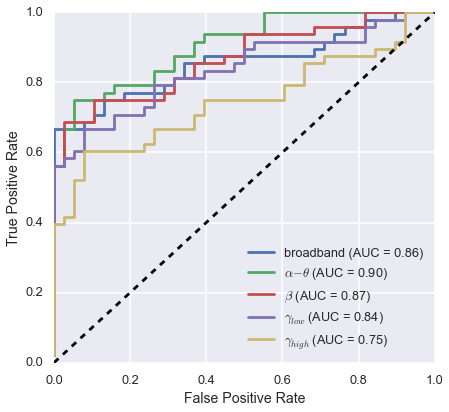

In [64]:
sb.set(context="poster", font_scale=0.8)
plt.figure(figsize=(6.5,6))
for freq in range(numfreqs):
    fpr, tpr, thresholds =metrics.roc_curve(resected_dict[sub_idx], strength_avg_dict[sub_idx][freq,:])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,label = '%s (AUC = %0.2f)' %(titles[freq],roc_auc))
    plt.legend(loc="lower right") 
plt.plot([0, 1], [0, 1], 'k--',label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()

# 5. Plot group-levels results of strength selectivity analysis

We plot the results of our strength selectivity analysis, initially using a z-score threshold of 1.

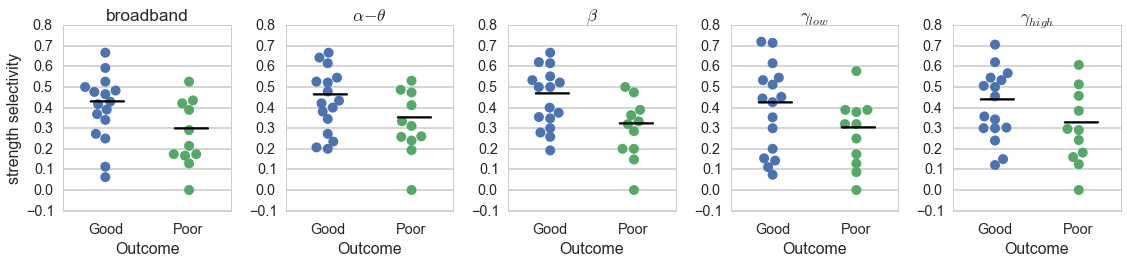

In [53]:
my_z=4
plt.figure(figsize=(16,4))
for freq_idx in range(numfreqs):
    axes = plt.subplot(1,numfreqs,freq_idx+1)
    sb.swarmplot(data=( np.squeeze(myscore[my_z ,freq_idx,good_idx]),np.squeeze(myscore[my_z ,freq_idx,bad_idx])),size=10 )
   
    sb.stripplot(data=([np.mean(myscore[my_z ,freq_idx,good_idx])],[np.mean(myscore[my_z ,freq_idx,bad_idx])]),size=40 ,color='k',marker="$-$")
    a=axes.get_xticks().tolist()
   
    if freq_idx ==0:
        plt.ylabel('strength selectivity')
    plt.xlabel('Outcome')
    a=['Good','Poor']
    axes.set_xticklabels(a)
    s,p = sp.stats.mannwhitneyu(np.squeeze(myscore[my_z,freq_idx,good_idx]),np.squeeze(myscore[my_z,freq_idx,bad_idx]))
    plt.title('%s'%(titles[freq_idx]))

plt.tight_layout()
#plt.savefig('strength_selectivity_z1.pdf')

Next, we evaluate our findings over a range of z thresholds.

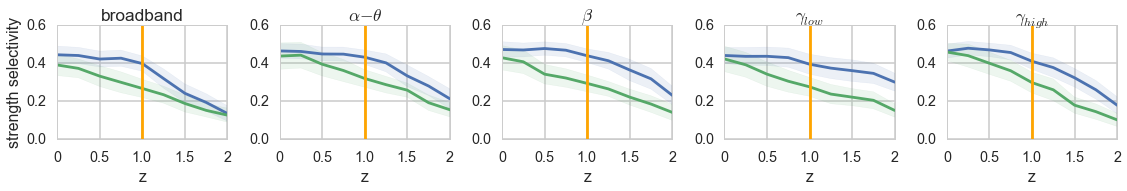

In [51]:
plt.figure(figsize=(16,3))
for freq_idx in range(numfreqs):
    axes = plt.subplot(1,numfreqs,freq_idx+1)
    p = plt.plot(np.mean(myscore[: ,freq_idx,good_idx],axis=2))
    color = p[0].get_color()   
    plt.fill_between(range(len(zvals)), np.squeeze(np.mean(myscore[: ,freq_idx,good_idx],axis=2)-sp.stats.sem(myscore[: ,freq_idx,good_idx],axis=2)) ,np.squeeze(np.mean(myscore[: ,freq_idx,good_idx],axis=2)+sp.stats.sem(myscore[: ,freq_idx,good_idx],axis=2)),  alpha = 0.1,color=color,interpolate=True) #,edgecolor='k'     
 
    p = plt.plot(np.mean(myscore[: ,freq_idx,bad_idx],axis=2))
    color = p[0].get_color()   
    plt.fill_between(range(len(zvals)), np.squeeze(np.mean(myscore[: ,freq_idx,bad_idx],axis=2)-sp.stats.sem(myscore[: ,freq_idx,bad_idx],axis=2)) ,np.squeeze(np.mean(myscore[: ,freq_idx,bad_idx],axis=2)+sp.stats.sem(myscore[: ,freq_idx,bad_idx],axis=2)),  alpha = 0.1,color=color,interpolate=True) #,edgecolor='k'     
 
    plt.xlabel('z')
    axes.locator_params(axis='x', nbins=5)
    locs, labels = plt.xticks()
    plt.xticks(locs, ([0,0.5,1.0,1.5,2]))
    if freq_idx ==0:
        plt.ylabel('strength selectivity')
    plt.title(titles[freq_idx])
    axes.locator_params(axis='y', nbins=5)
    ymin, ymax = plt.ylim()
    plt.ylim()
    plt.plot([4,4],[0,0.6],'orange' )   
plt.tight_layout()
plt.savefig('strength_selectivity_zsweep.pdf')

Finally, we assess significance using a two-sided permutation-based test.

In [59]:
for freq_idx in range(numfreqs):
    print titles[freq_idx]
    for zidx,my_z in enumerate(zvals):
        print 'z =' + str(my_z),
        p = perm_p_val(np.squeeze(myscore[zidx,freq_idx,good_idx]),np.squeeze(myscore[zidx,freq_idx,bad_idx]))
        print 'p =' + str(p)

broadband
z =0 p =0.4593
z =0.25 p =0.3237
z =0.5 p =0.1918
z =0.75 p =0.0737
z =1 p =0.0497
z =1.25 p =0.2418
z =1.5 p =0.4492
z =1.75 p =0.5138
z =2 p =0.8833
$\alpha-\theta$
z =0 p =0.7127
z =0.25 p =0.7922
z =0.5 p =0.4252
z =0.75 p =0.2013
z =1 p =0.0759
z =1.25 p =0.1014
z =1.5 p =0.325
z =1.75 p =0.2179
z =2 p =0.4273
$\beta$
z =0 p =0.5471
z =0.25 p =0.3626
z =0.5 p =0.0354
z =0.75 p =0.0167
z =1 p =0.018
z =1.25 p =0.0248
z =1.5 p =0.0738
z =1.75 p =0.0883
z =2 p =0.1874
$\gamma_{low}$
z =0 p =0.8182
z =0.25 p =0.567
z =0.5 p =0.2424
z =0.75 p =0.1185
z =1 p =0.1318
z =1.25 p =0.0954
z =1.5 p =0.0887
z =1.75 p =0.0703
z =2 p =0.0269
$\gamma_{high}$
z =0 p =0.9312
z =0.25 p =0.5557
z =0.5 p =0.2855
z =0.75 p =0.1525
z =1 p =0.1144
z =1.25 p =0.1426
z =1.5 p =0.0449
z =1.75 p =0.1057
z =2 p =0.2203


# 6. Run Edge-level analysis

To assess what types of connections were contributing to the observed differences in strength selectivity in good vs. poor outcome patients, we delineated the following three edge types: (i) connections between nodes within the RZ (RZ-RZ), (ii) connections between one node within the RZ and one node outside the RZ (RZ-OUT), and (iii) connections between nodes outside the RZ (OUT-OUT). For each subject, we computed the mean edge weights within each of these categories. We compared the mean edge weights between these three categories within both good and poor outcome patients. Furthermore, we computed differences in these categories between the two patient groups. 

In [65]:
# Edge Analysis
within_RZ = np.zeros((len(subjects),len(freq_bands_adj)))
between_RZ = np.zeros((len(subjects),len(freq_bands_adj)))
outside_RZ =np.zeros((len(subjects),len(freq_bands_adj)))

z_within_RZ = np.zeros((len(subjects),len(freq_bands_adj)))
z_between_RZ = np.zeros((len(subjects),len(freq_bands_adj)))
z_outside_RZ =np.zeros((len(subjects),len(freq_bands_adj)))

within_RZ_nulls = {}
between_RZ_nulls ={}
outside_RZ_nulls ={}

for sub_idx, subject in enumerate(subjects):

    res_idxs = resected_dict[sub_idx]
    num_resected = int(np.sum(res_idxs))
    numchans = len(electrodes_dict[sub_idx])
    notres_mask = res_idxs == 0
    notres_idxs = np.where(notres_mask)
    num_notresected = int(np.sum(notres_mask))
    
    within_RZ_nulls_chan =  np.zeros((len(freq_bands_adj),num_notresected))
    between_RZ_nulls_chan = np.zeros((len(freq_bands_adj),num_notresected))
    outside_RZ_nulls_chan = np.zeros((len(freq_bands_adj),num_notresected))
    
    for freq_idx, myfreq in enumerate(freq_bands_adj):
        myadj = np.nanmean(adjs[sub_idx][freq_idx,:,:,:],axis=2)
        myadj = (myadj - np.nanmean(myadj)) / np.nanstd(myadj)
        
        di = np.diag_indices(np.shape(myadj)[0])
        myadj[di] = np.nan
        
        within_RZ[sub_idx,freq_idx] = np.nanmean(myadj[res_idxs == 1,:][:,res_idxs == 1])
        between_RZ[sub_idx,freq_idx] = np.nanmean(myadj[res_idxs == 1,:][:,res_idxs == 0])
        outside_RZ[sub_idx,freq_idx] = np.nanmean(myadj[res_idxs == 0,:][:,res_idxs == 0])
        
        sub_distmat = sio.loadmat(basefolder + subject + '/' + subject + '_distmat_final.mat')['distmat']

        for idxs, i in enumerate(np.squeeze(notres_idxs)):           
            nullres_idxs = sub_distmat[i,:].argsort()[:num_resected]          
            nullnotres_idxs = [x for x in range(numchans) if x not in nullres_idxs]        
            within_RZ_nulls_chan[freq_idx,idxs] = np.nanmean(myadj[nullres_idxs,:][:,nullres_idxs])
            between_RZ_nulls_chan[freq_idx,idxs] = np.nanmean(myadj[nullres_idxs,:][:,nullnotres_idxs])
            outside_RZ_nulls_chan[freq_idx,idxs] = np.nanmean(myadj[nullnotres_idxs,:][:,nullnotres_idxs])
         
        z_within_RZ[sub_idx,freq_idx] = (within_RZ[sub_idx,freq_idx] - np.nanmean(within_RZ_nulls_chan[freq_idx,:]))/np.nanstd(within_RZ_nulls_chan[freq_idx,:])
        z_between_RZ[sub_idx,freq_idx] = (between_RZ[sub_idx,freq_idx] - np.nanmean(between_RZ_nulls_chan[freq_idx,:]))/np.nanstd(between_RZ_nulls_chan[freq_idx,:])
        z_outside_RZ[sub_idx,freq_idx] = (outside_RZ[sub_idx,freq_idx] - np.nanmean(outside_RZ_nulls_chan[freq_idx,:]))/np.nanstd(outside_RZ_nulls_chan[freq_idx,:])
    

We plot the results of these edge-level findings:

0.0179870069503
0.0798068825133
0.0140490575447
0.0159138685975
0.0287273540445


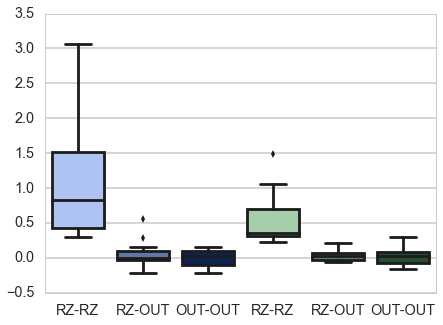

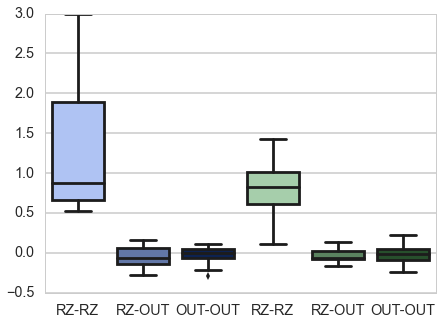

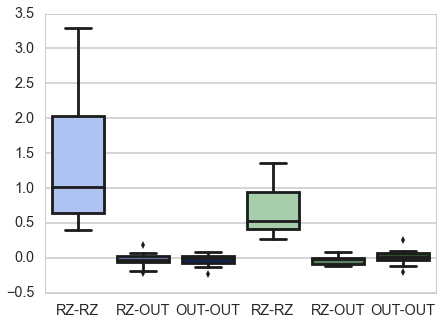

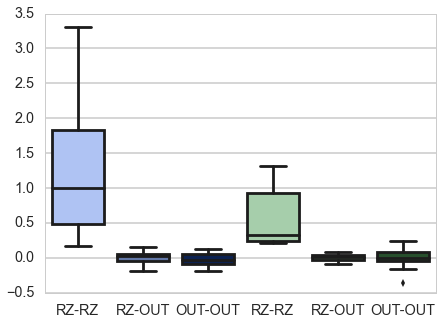

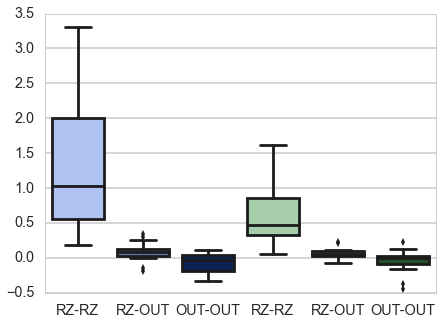

In [69]:
for freq_idx, myfreq in enumerate(freq_bands_adj):
    plt.figure(figsize=(7,5))
    axes = sb.boxplot(data=([np.squeeze(within_RZ[good_idx,freq_idx]),np.squeeze(between_RZ[good_idx,freq_idx]),np.squeeze(outside_RZ[good_idx,freq_idx]),np.squeeze(within_RZ[bad_idx,freq_idx]), np.squeeze(between_RZ[bad_idx,freq_idx]), np.squeeze(outside_RZ[bad_idx,freq_idx])]),palette=mycmap)
    s,p = sp.stats.mannwhitneyu(np.squeeze(within_RZ[good_idx,freq_idx]), np.squeeze(within_RZ[bad_idx,freq_idx]))  
    a=axes.get_xticks().tolist()   
    a=['RZ-RZ','RZ-OUT','OUT-OUT','RZ-RZ','RZ-OUT','OUT-OUT']
    axes.set_xticklabels(a)
    print p 

Given that neighboring electrodes are more likely to be highly correlated due to spatial proximity or due to common source measurements, we generated a spatially-constrained null model to ensure our findings were not a result of chance. To do this, for each patient with N resected electrodes, we sampled clusters of N spatially contiguous electrodes, using Euclidean distance to determine the closest electrodes. We repeated our edge-weight analysis after normalizing the RZ-RZ, RZ-OUT and OUT-OUT edge weights by the null distribution of edge weights for each category

0.0873865746356
0.0727352786323
0.0491548869849
0.0443355209305
0.0399044127818


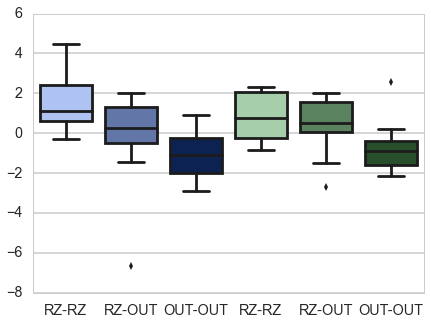

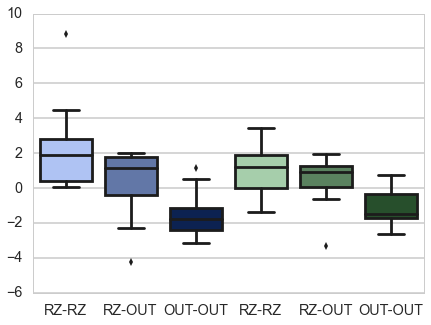

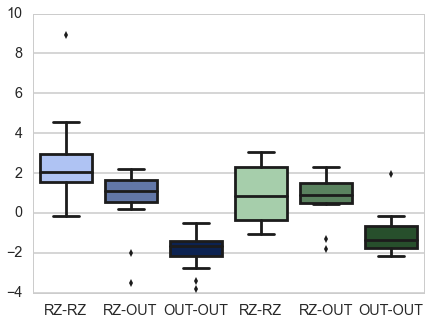

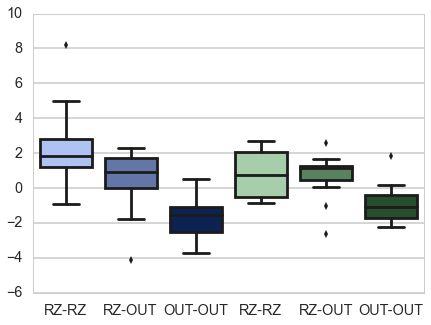

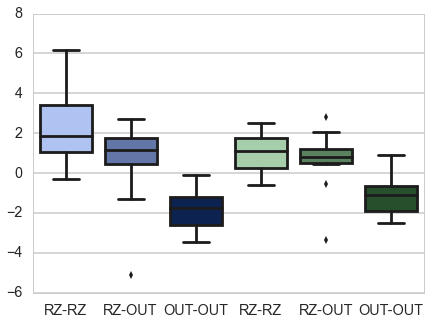

In [70]:
for freq_idx, myfreq in enumerate(freq_bands_adj):
    plt.figure(figsize=(7,5))
    axes = sb.boxplot(data=([np.squeeze(z_within_RZ[good_idx,freq_idx]),np.squeeze(z_between_RZ[good_idx,freq_idx]),np.squeeze(z_outside_RZ[good_idx,freq_idx]),np.squeeze(z_within_RZ[bad_idx,freq_idx]), np.squeeze(z_between_RZ[bad_idx,freq_idx]), np.squeeze(z_outside_RZ[bad_idx,freq_idx])]),palette=mycmap)    
    s,p = sp.stats.mannwhitneyu(np.squeeze(z_within_RZ[good_idx,freq_idx]), np.squeeze(z_within_RZ[bad_idx,freq_idx]))   
    a=axes.get_xticks().tolist()  
    a=['RZ-RZ','RZ-OUT','OUT-OUT','RZ-RZ','RZ-OUT','OUT-OUT']
    axes.set_xticklabels(a)
    print p                                     

# 7. Test similarity of networks across frequency bands

We generate a matrix of similarity values between functional networks generated using different frequency bands. Similarity values were obtained by measuring Pearson correlation between edges in each pair of networks for each subject, and subsequently averaging these correlations across subjects. 

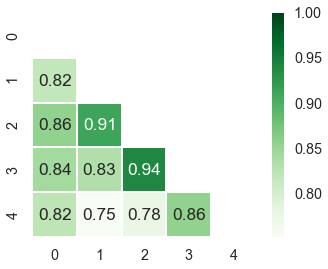

In [71]:
adj_corr_mean = np.zeros((numfreqs,numfreqs))
for sub_idx, subject in enumerate(subjects):
    adj_list = np.vstack((mat2line(np.nanmean(adjs[sub_idx][0,:,:,:],axis=2)), mat2line(np.nanmean(adjs[sub_idx][1,:,:,:],axis=2)), mat2line(np.nanmean(adjs[sub_idx][2,:,:,:],axis=2)), mat2line(np.nanmean(adjs[sub_idx][3,:,:,:],axis=2)), mat2line(np.nanmean(adjs[sub_idx][4,:,:,:],axis=2))))
    adj_corr = 1-sp.spatial.distance.squareform(sp.spatial.distance.pdist(adj_list, metric='correlation'))
    adj_corr_mean = adj_corr_mean + adj_corr

adj_corr_mean = adj_corr_mean / len(subjects)

mask = np.zeros_like(adj_corr_mean)
mask[np.triu_indices_from(mask)] = True

plt.figure()
sb.heatmap(adj_corr_mean,mask=mask,annot=True,linewidths=.5,square=True,cmap='Greens')
#plt.savefig('heatmap_frequency_corrs.pdf')

Here is an example of the correlation line for one pair of frequencies in one example subject 

In [ ]:
sub_idx=12
sb.set(context="poster", font_scale=1)
sb.set_style("white")
sb.jointplot(mat2line(np.nanmean(adjs[sub_idx][0,:,:,:],axis=2)), mat2line(np.nanmean(adjs[sub_idx][4,:,:,:],axis=2)),kind="reg")
#plt.savefig('Example_matrix.pdf')

# 8. Additional Visualizations

We can visualize our findings spatially (i.e. on the brain surface) using tools such as Blender or BrainNet Viewer.

In [ ]:
# Uncomment to generate edge/node data for visualization in BrainNet Viewer
#for sub_idx, subject in enumerate(subjects):
#    for freq_idx, myfreq in enumerate(freq_bands_adj):
#        adj = np.nanmean(adjs[sub_idx][freq_idx,:,:,:],axis=2)
#        di = np.diag_indices(np.shape(adj)[0])
#        adj[di] = np.nan
#        z_adj = (adj - np.nanmean(adj)) / np.nanstd(adj)
#        z_adj[di] = 0

#        node_filename = basefolder + subject + '/' + subject + '_allselected.node'
#        node_data = pd.read_csv(node_filename, header = None,delimiter=' ')
#        node_data[5] = electrodes_dict[sub_idx]
#        node_data[3] = strength_avg_dict[sub_idx][freq_idx,:]  
        # can add a line of code here to save node file if desired.
#        np.savetxt(basefolder + subject + '/' + subject + '_allselected' + myfreq + '.edge', z_adj,fmt='%10.9f', delimiter=' ')